In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"

!wget $data -O churn_data.csv

In [3]:
df = pd.read_csv('churn_data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/ksilas/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

#### **Accuracy and Dummy Model**

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
thresholds = np.linspace(0,1,21)

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t,score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


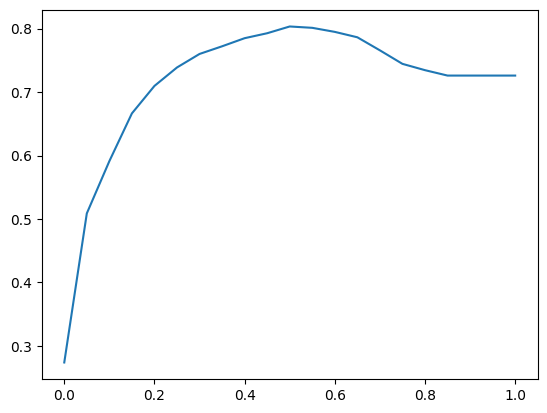

In [13]:
plt.plot(thresholds,scores)

In [14]:
from collections import Counter

In [15]:
Counter(y_pred >= 1)

Counter({False: 1409})

#### Confusion Table

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5 
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [19]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [20]:
(tp,tn,fp,fn)

(210, 922, 101, 176)

In [21]:
confusion_matrix = np.array([
    [tn,fp],
    [fn,tp]
])

In [22]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

#### Precision and Recall

In [23]:
# number of correct true predicted 
# fraction of correct predictions 
# fractions of positive predictions that are correct

p = (tp) / (fp + tp)
p

0.6752411575562701

In [24]:
# Recall 
# fraction of correctly identified positive examples
r = tp / (tp + fn)

In [25]:
r

0.5440414507772021

#### ROC Curves
Used to describe the performance of binary classification model

In [26]:
trp = tp / (tp + fn)
frp = fp / (fp + tn)

In [27]:
trp, frp

(0.5440414507772021, 0.09872922776148582)

In [28]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t,tp,fp,fn,tn))

In [29]:
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 330, 341, 56, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 304, 70, 719),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [30]:
columns = ['threshold','tp','fp','fn','tn']
scores_df = pd.DataFrame(scores, columns=columns)

scores_df['tpr'] = scores_df.tp / (scores_df.tp + scores_df.fn)
scores_df['fpr'] = scores_df.fp / (scores_df.fp + scores_df.tn)

In [31]:
scores_df['tpr'] = scores_df.tp / (scores_df.tp + scores_df.fn)
scores_df['fpr'] = scores_df.fp / (scores_df.fp + scores_df.tn)

In [32]:
scores_df[:10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
5,0.05,379,685,7,338,0.981865,0.669599
6,0.06,377,661,9,362,0.976684,0.646139
7,0.07,372,641,14,382,0.963731,0.626588
8,0.08,371,613,15,410,0.961140,0.599218
9,0.09,369,580,17,443,0.955959,0.566960


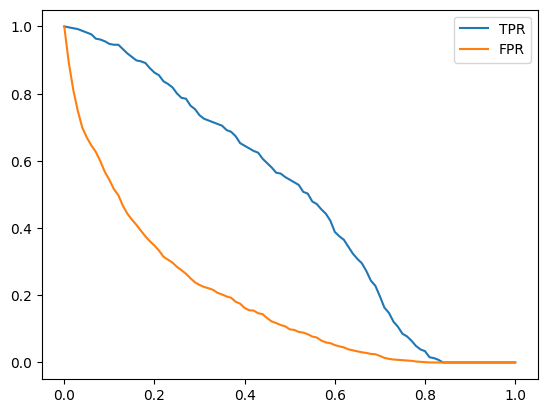

In [33]:
plt.plot(scores_df.threshold,scores_df['tpr'],label='TPR')
plt.plot(scores_df.threshold, scores_df['fpr'],label='FPR')
plt.legend()
plt.show()

##### Random Model

In [34]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))

In [35]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [36]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [37]:
df_rand = tpr_fpr_dataframe(y_val,y_rand)

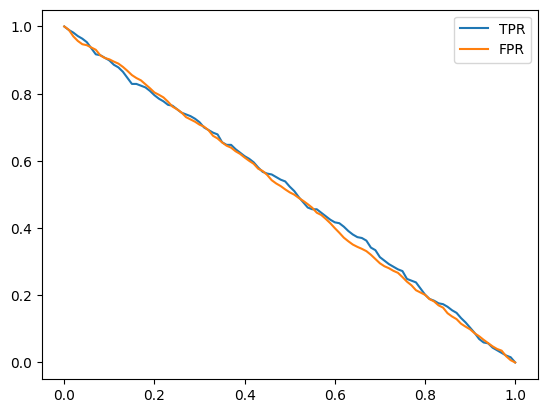

In [38]:
plt.plot(df_rand.threshold,df_rand['tpr'],label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'],label='FPR')
plt.legend()
plt.show()

##### Ideal Model

In [39]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg,num_pos

(1023, 386)

In [40]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [42]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [44]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [45]:
df_ideal = tpr_fpr_dataframe(y_ideal,y_ideal_pred)

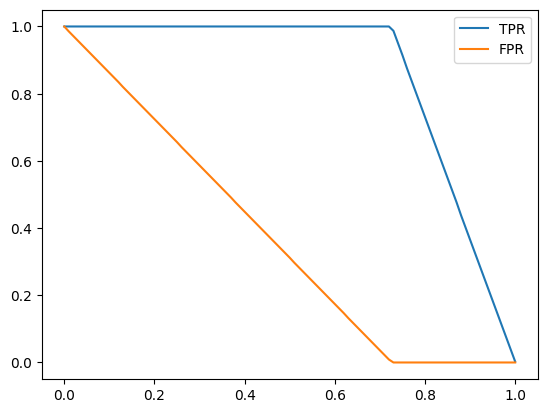

In [47]:
plt.plot(df_ideal.threshold,df_ideal['tpr'],label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'],label='FPR')
plt.legend()
plt.show()

##### Everything together

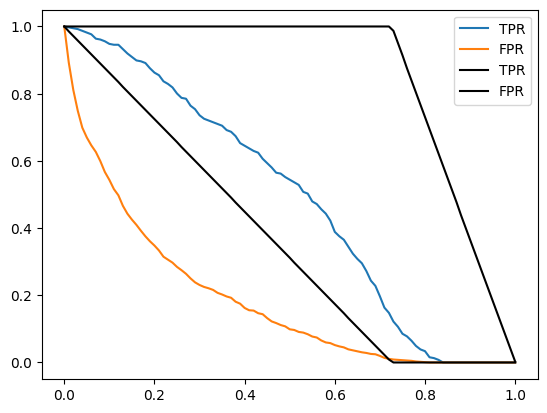

In [51]:
plt.plot(scores_df.threshold,scores_df['tpr'],label='TPR')
plt.plot(scores_df.threshold, scores_df['fpr'],label='FPR')

# plt.plot(df_rand.threshold,df_rand['tpr'],label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'],label='FPR')

plt.plot(df_ideal.threshold,df_ideal['tpr'],label='TPR', color="black")
plt.plot(df_ideal.threshold, df_ideal['fpr'],label='FPR', color="black")
plt.legend()
plt.show()

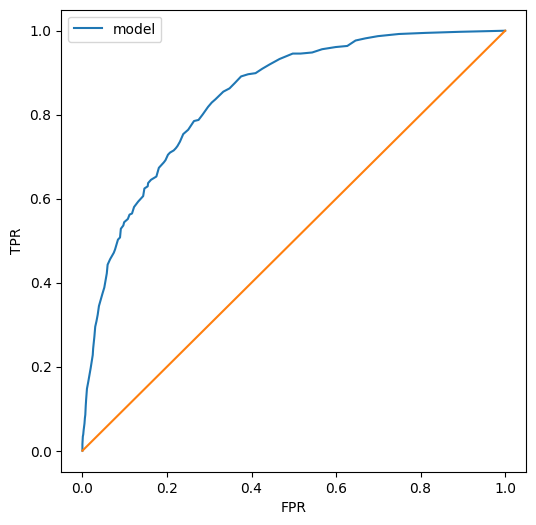

In [57]:
plt.figure(figsize=(6,6))
plt.plot(scores_df.fpr,scores_df.tpr, label="model")
plt.plot([0,1],[0,1])

# plt.plot(df_rand.fpr,df_rand.tpr, label="Random")
# plt.plot(df_ideal.fpr,df_ideal.tpr,label="Ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [58]:
# using sklearn for ROC curve
from sklearn.metrics import roc_curve

In [59]:
fpr,tpr,thresholds = roc_curve(y_val,y_pred)

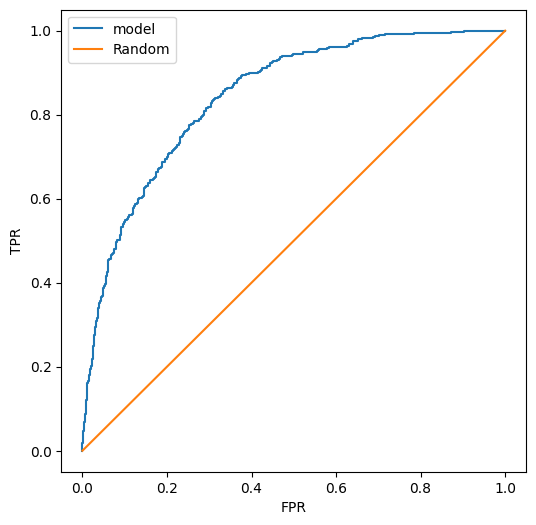

In [60]:
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr, label="model")
plt.plot([0,1],[0,1], label="Random")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()
plt.show()

##### ROC AUC